In [118]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip

torch.set_grad_enabled(False)

device = "cuda"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Source Frames

In [135]:
from text3d2video.artifacts.mesh_artifact import MeshArtifact
from text3d2video.utilities.camera_placement import turntable_extrinsics
from pytorch3d.renderer import FoVPerspectiveCameras
from text3d2video.utilities.ipython_utils import display_vid

# read mesh
mesh_art = MeshArtifact.from_wandb_artifact_tag("mixamo-human:latest")
mesh = normalize_meshes(mesh_art.mesh(device))

# setup src cam
angles = [0]
elevs = [0]
R, T = turntable_extrinsics(dists=1.5, angles=angles, elevs=elevs)
src_cam = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=40)
src_mesh = mesh.extend(len(src_cam))

src_verts_uvs, src_faces_uvs = mesh_art.uv_data()

# render src depths
depths = render_depth_map(src_mesh, src_cam)
display_vid(pil_frames_to_clip(depths))

## Target Frames

In [311]:
from text3d2video.utilities.camera_placement import front_facing_extrinsics
from text3d2video.utilities.ipython_utils import display_vid

angles = torch.linspace(0, 180, 5)
R, T = front_facing_extrinsics(degrees=angles)
tgt_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=40)
tgt_meshes = mesh.extend(len(tgt_cams))

tgt_verts_uvs, tgt_faces_uvs = mesh_art.uv_data()

# render tgt depths
tgt_depths = render_depth_map(tgt_meshes, tgt_cams)
display_vid(pil_frames_to_clip(tgt_depths))

# Feature extraction on source

In [312]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline
from diffusers import DDIMScheduler

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
extraction_pipe = load_pipeline(
    TexturingPipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [313]:
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.sd_feature_extraction import AttnType, BlockType, find_attn_layers

sa_up_layers = find_attn_layers(
    extraction_pipe.unet,
    block_types=[BlockType.MID, BlockType.UP],
    layer_types=[AttnType.SELF_ATTN],
)

cfg = TexturingConfig(
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=sa_up_layers,
)

In [277]:
generator = torch.Generator(device="cuda")
generator.manual_seed(1)

prompt = 'Deadpool'

video_frames = extraction_pipe(
    [prompt] * len(src_cam),
    src_mesh,
    src_cam,
    src_verts_uvs,
    src_faces_uvs,
    conf=cfg,
    generator=generator,
)

100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


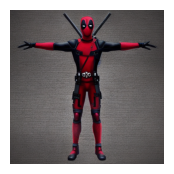

<Figure size 640x480 with 0 Axes>

In [278]:
from text3d2video.utilities.ipython_utils import display_ims

display_ims(video_frames)

In [279]:
import os
from pathlib import Path

from text3d2video.utilities.logging import H5Logger

logged_features = H5Logger(Path("features.h5"))
logged_features.open_read()
_ = os.system("du -h features.h5")
logged_features.fields()

6,7G	features.h5


['bg_noise', 'kvs', 'tex', 'uv_noise']

# Feature Injection Pipeline

In [280]:
from text3d2video.pipelines.rd_2_pipeline import FeatureInjectionPipeline

pipe_injection = load_pipeline(
    FeatureInjectionPipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:51<00:00,  3.43s/it]


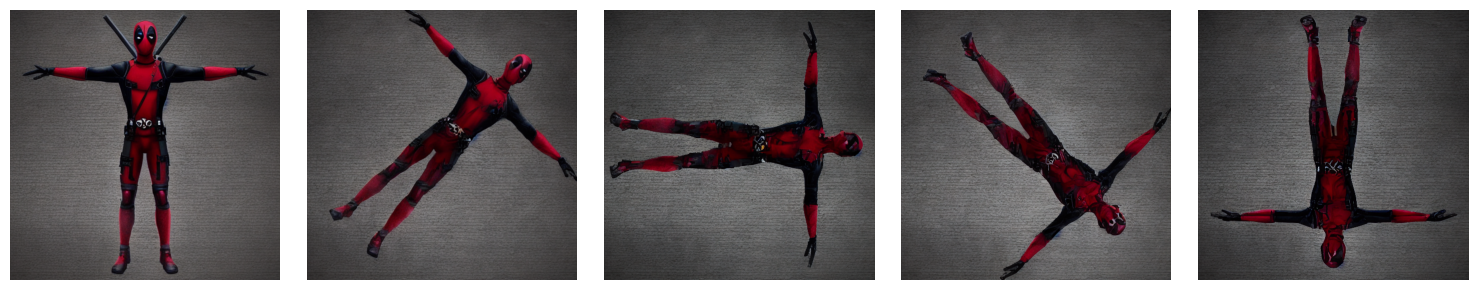

In [377]:
from text3d2video.pipelines.rd_2_pipeline import FeatureInjectionConfig
from text3d2video.utilities.logging import GrLogger

rd_config = FeatureInjectionConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    chunk_size=5,
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=2,
    module_paths=sa_up_layers,
    time_threshold=1.0,
    layer_threshold=1.0,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(2)

logger = GrLogger(Path("data.h5"), n_save_times=10, n_save_frames=None)
logger.enabled = True
logger.delete_data()
logger.open_write()

frames_injection = pipe_injection(
    "Deadpool",
    tgt_meshes,
    tgt_cams,
    tgt_verts_uvs,
    tgt_faces_uvs,
    rd_config,
    logged_features,
    generator=generator,
    logger=logger,
)

display_ims(frames_injection, scale=3)

In [378]:
field = "qry"
keys_and_vals = logger.field_keys_and_vals(field)
frames = keys_and_vals["frame_i"]
layers = keys_and_vals["layer"]
ts = sorted(keys_and_vals["t"], reverse=True)

layer = layers[-1]
t = ts[0]
frame = frames[0]

In [379]:
from text3d2video.sd_feature_extraction import AttnLayerId


attn_layers = [AttnLayerId.parse(l) for l in layers]
attn_layers = sorted(attn_layers, key=lambda x: x.unet_absolute_index())
attn_layers = [layer for layer in attn_layers if layer.block_type == BlockType.UP]


modules = [layer.module_path() for layer in attn_layers]
modules

['up_blocks.1.attentions.0.transformer_blocks.0.attn1',
 'up_blocks.1.attentions.1.transformer_blocks.0.attn1',
 'up_blocks.1.attentions.2.transformer_blocks.0.attn1',
 'up_blocks.2.attentions.0.transformer_blocks.0.attn1',
 'up_blocks.2.attentions.1.transformer_blocks.0.attn1',
 'up_blocks.2.attentions.2.transformer_blocks.0.attn1',
 'up_blocks.3.attentions.0.transformer_blocks.0.attn1',
 'up_blocks.3.attentions.1.transformer_blocks.0.attn1',
 'up_blocks.3.attentions.2.transformer_blocks.0.attn1']

In [380]:
import math
from einops import rearrange

chunk = "chunk_1"
qrys = [
    logger.read("qry", frame_i=f, layer=layer, t=t, chunk=chunk, return_pt=True)
    for f in frames
]
qrys = torch.stack(qrys)
res = int(math.sqrt(qrys.shape[1]))

qrys_2D = rearrange(qrys, "b (h w) c -> b c h w", h=res, w=res)
qrys_2D.shape

torch.Size([5, 320, 64, 64])

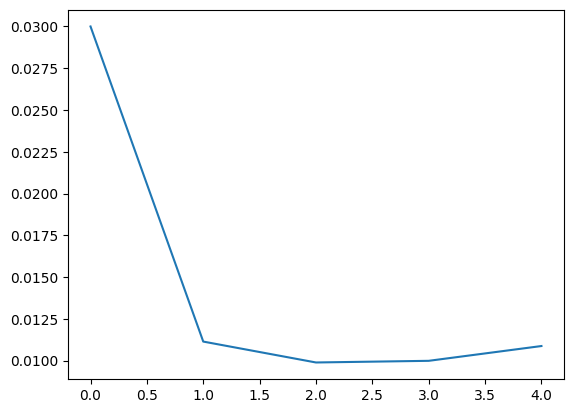

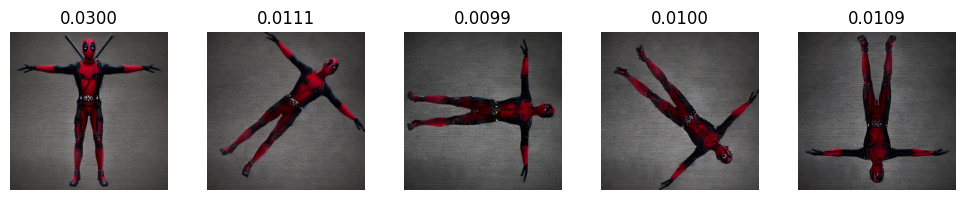

In [381]:
from matplotlib import pyplot as plt
import numpy as np
from text3d2video.utilities.attn_vis import calc_attn_weights_all_heads


def estimate_mismatch(frame):
    kwargs = {"frame_i": frame, "layer": modules[-1], "t": ts[-1], "chunk": chunk}

    qry = logger.read("qry", **kwargs, return_pt=True)
    key = logger.read("key", **kwargs, return_pt=True)

    attn_weights = calc_attn_weights_all_heads(qry, key)

    max_per_pixel = attn_weights.max(dim=0).values
    return max_per_pixel.mean().item()


errors = [estimate_mismatch(f) for f in frames]

plt.plot(errors)

errors_str = [f"{e:.4f}" for e in errors]
display_ims(frames_injection, titles=errors_str)

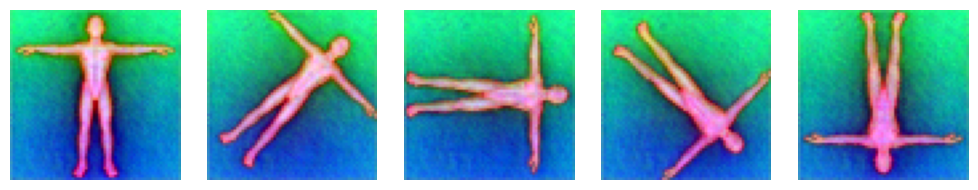

In [382]:
from text3d2video.feature_visualization import RgbPcaUtil


qry_im = qrys_2D[0]
qry_feats = rearrange(qry_im, "c h w -> (h w) c")
pca = RgbPcaUtil.init_from_features(qry_feats)
qry_ims = [pca.feature_map_to_rgb_pil(qry_im) for qry_im in qrys_2D]
display_ims(qry_ims)